In [ ]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import os

# Initial EDA

In [ ]:
load_dotenv()
DATA_PATH = os.getenv("DATA_PATH")

In [ ]:
d_data = pd.read_csv(DATA_PATH + '/Stud_E-mobility_data_dynamicLimit.csv')
s_data = pd.read_csv(DATA_PATH + '/Stud_E-mobility_data_staticLimit.csv')

The two datasets differ in the way supply from the grid is limited. `s_data` contains static limit of 50kW, while `d_data` has a dynamic limit that changes over time. Perhaps to avoid higher loads on the grid at suboptimmaltimes of the day (when a lot of people use electricity)?

In [ ]:
s_data["POWER_DEMAND"] = s_data["WALLBOX_1_POWER"] + s_data["WALLBOX_2_POWER"] + s_data["WALLBOX_3_POWER"] + s_data["WALLBOX_A_POWER"] + s_data["WALLBOX_B_POWER"] + s_data["WALLBOX_C_POWER"] + s_data["WALLBOX_FASTCHARGER_POWER"]
s_data["POWER_SUPPLY"] = s_data["GARAGE_EXTERNAL_POWER"] + s_data["PV_POWER"] + s_data["BATTERY_DISCHARGE_POWER"]

In [ ]:
s_data.describe()

,GARAGE_EXTERNAL_POWER,DEMAND_LIMIT,DEMAND_LIMIT_INDICATOR,BATTERY_SOC,BATTERY_DISCHARGE_POWER,BATTERY_CHARGED_ENERGY,BATTERY_DISCHARGED_ENERGY,PV_POWER,PV_ENERGY,WALLBOX_ALPHA_ENERGY,...,WALLBOX_A_ENERGY,WALLBOX_A_POWER,WALLBOX_B_ENERGY,WALLBOX_B_POWER,WALLBOX_C_ENERGY,WALLBOX_C_POWER,WALLBOX_FASTCHARGER_ENERGY,WALLBOX_FASTCHARGER_POWER,POWER_DEMAND,POWER_SUPPLY
count,59442.000000,59442.0,59442.0,59442.000000,59442.000000,59442.000000,59442.000000,59442.000000,59442.000000,59442.000000,...,59442.000000,59442.000000,59442.000000,59442.000000,59442.000000,59442.000000,59442.000000,59442.000000,59442.000000,59442.000000
mean,16.289759,50.0,1.0,40.146942,-0.464677,0.058751,0.050882,0.725957,0.012497,0.013051,...,0.017482,1.015422,0.018566,1.051943,0.025252,1.435265,0.169159,9.665066,15.242758,16.551039
std,19.406290,0.0,0.0,5.453018,14.480506,0.358806,0.339166,1.309800,0.067592,0.324930,...,3.043279,2.521278,0.161284,2.722164,0.286048,3.194861,1.120542,22.522631,23.876519,24.569700
min,-9.283169,50.0,1.0,7.500000,-53.692001,0.000000,-0.101562,-0.039667,0.000000,0.000000,...,-524.167969,0.009783,-0.017578,0.009795,0.000000,0.009802,0.000000,0.009000,0.147030,-23.178345
25%,1.244171,50.0,1.0,40.500000,-0.482000,0.000000,0.000000,0.006161,0.000000,0.000000,...,0.000000,0.010202,0.000000,0.010320,0.000000,0.010211,0.000000,0.150472,0.197642,0.901735
50%,6.699247,50.0,1.0,40.500000,-0.351000,0.000000,0.000000,0.008210,0.000000,0.000000,...,0.000000,0.010252,0.000000,0.010370,0.000000,0.010260,0.000000,0.159256,5.223808,5.885979
75%,26.031271,50.0,1.0,41.000000,-0.225000,0.000000,0.000000,0.887282,0.015625,0.000000,...,0.000977,0.010340,0.000977,0.010431,0.001953,0.010552,0.007812,0.169050,15.560868,16.702183
max,112.929680,50.0,1.0,54.500000,72.433006,65.699219,55.500000,7.470151,14.628906,76.445312,...,524.398438,11.637885,31.630859,11.531826,68.082031,11.560207,190.648438,80.319511,117.407838,129.619329


Sanity check above shows some potential anomalies:



    - What does negative external power mean?
    - One of the ground truth rules mentioned in the Danilo's email proposes SOC>80% to be one of the thresholds. There are no such instances in our dataset?
    - Does negative battery discharge power mean load on the grid? Should it be counted along with other power demands?
    - Also negative PV Power just doesn't make sense
    - What are wallbox energies?

In [ ]:
#convert _time column into timestamp
s_data['_time'] = pd.to_datetime(d_data['_time'])

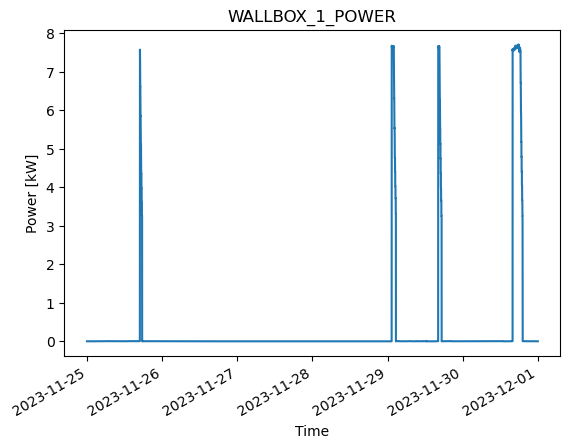

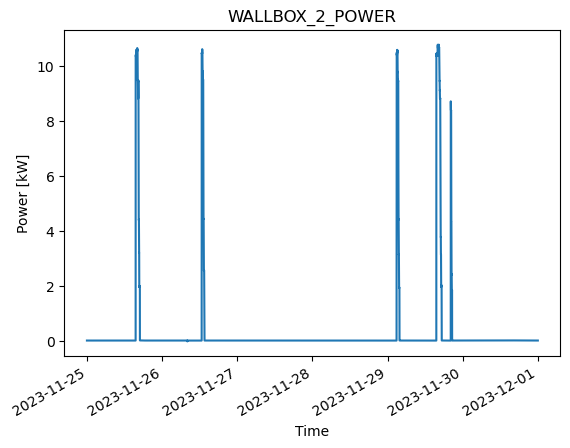

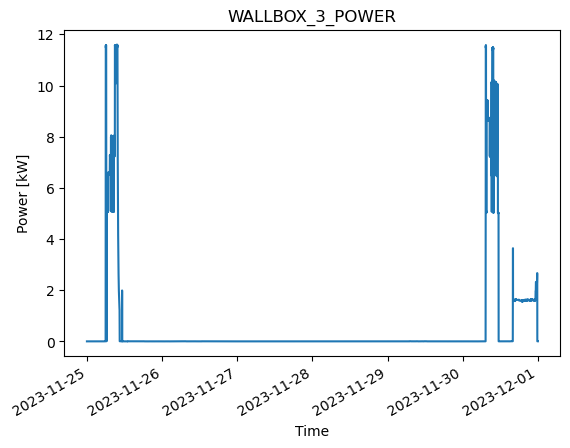

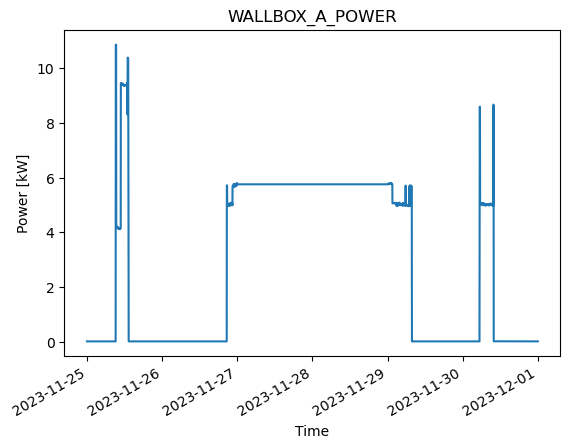

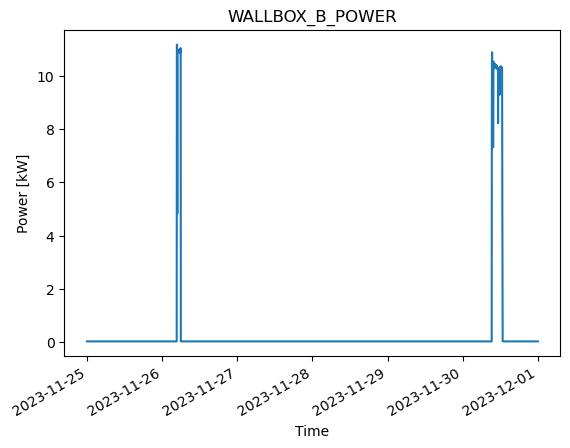

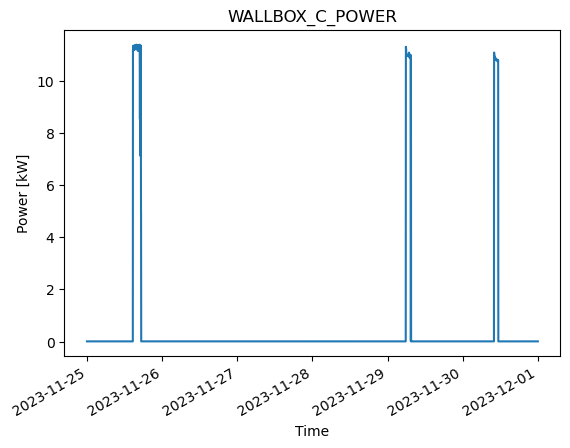

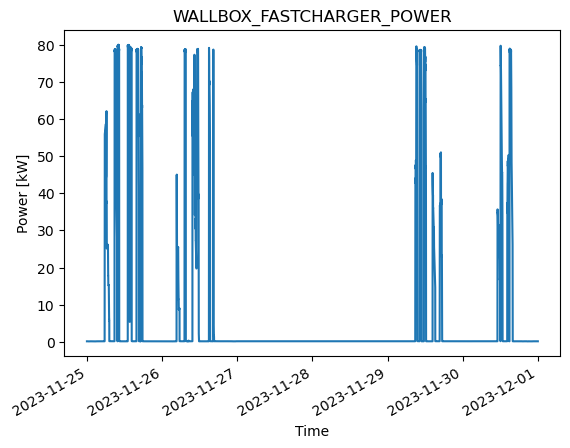

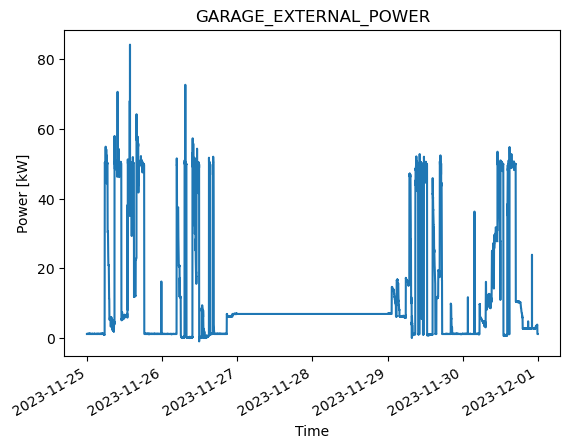

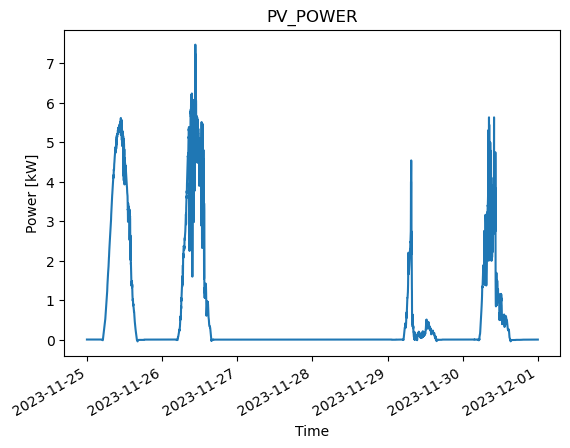

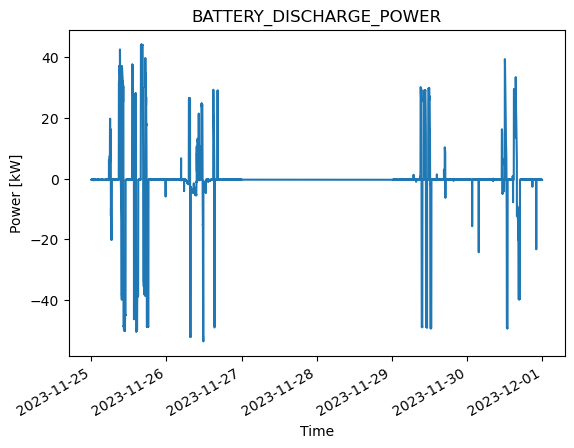

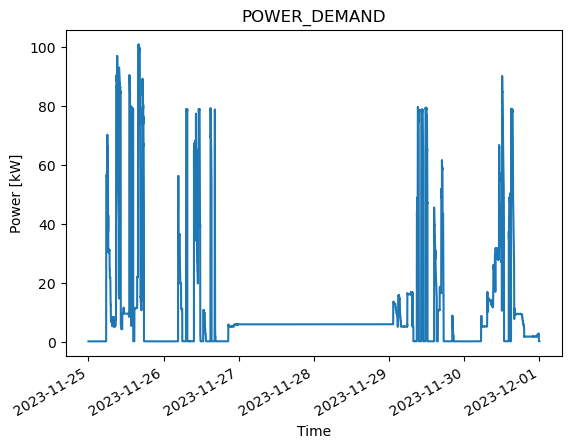

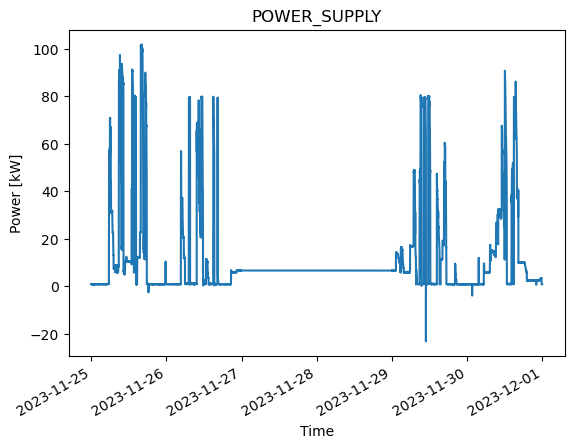

In [ ]:
""" 
Plotting the most interesting columns. One week of data is plotted.
"""
start_date = pd.to_datetime('2023-11-24').tz_localize('UTC')  # replace with your start date
end_date = start_date + pd.DateOffset(weeks=1)

interesting_columns = ["WALLBOX_1_POWER", "WALLBOX_2_POWER", "WALLBOX_3_POWER", "WALLBOX_A_POWER", "WALLBOX_B_POWER", "WALLBOX_C_POWER", "WALLBOX_FASTCHARGER_POWER", "GARAGE_EXTERNAL_POWER", "PV_POWER", "BATTERY_DISCHARGE_POWER", "POWER_DEMAND", "POWER_SUPPLY"]

week_data = s_data[(s_data['_time'] >= start_date) & (s_data['_time'] < end_date)]
for column in interesting_columns:
    week_data.plot(x='_time', y=column, legend=False)
    plt.xlabel('Time')
    plt.ylabel("Power [kW]")
    plt.title(column)


In [ ]:
s_data["POWER_DEMAND_EXCEEDS_SUPPLY"] = s_data["POWER_DEMAND"] > s_data["POWER_SUPPLY"]
s_data["POWER_EXCEEDS_LIMIT"] = s_data["GARAGE_EXTERNAL_POWER"] > s_data["DEMAND_LIMIT"]
s_data["POWER_EXCEEDS_LIMIT"].value_counts()

POWER_EXCEEDS_LIMIT
False    54892
True      4550
Name: count, dtype: int64

I'm not sure what this is supposed to mean? What would cause supply/demand to diverge? Energy has to come from somewhere....

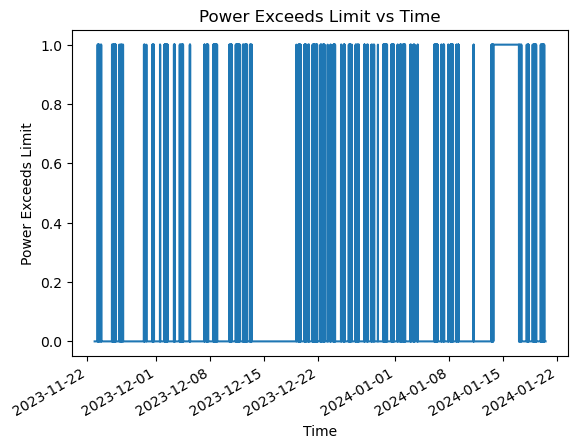

In [ ]:
s_data["POWER_EXCEEDS_LIMIT"] = s_data["POWER_EXCEEDS_LIMIT"].astype(int)
s_data.plot(x='_time', y='POWER_EXCEEDS_LIMIT', legend=False)
plt.xlabel('Time')
plt.ylabel('Power Exceeds Limit')
plt.title('Power Exceeds Limit vs Time')
plt.show()

In [ ]:
s_data[s_data["GARAGE_EXTERNAL_POWER"] > s_data["DEMAND_LIMIT"]].head()

,_time,GARAGE_EXTERNAL_POWER,DEMAND_LIMIT,DEMAND_LIMIT_INDICATOR,BATTERY_SOC,BATTERY_DISCHARGE_POWER,BATTERY_CHARGED_ENERGY,BATTERY_DISCHARGED_ENERGY,PV_POWER,PV_ENERGY,...,WALLBOX_B_ENERGY,WALLBOX_B_POWER,WALLBOX_C_ENERGY,WALLBOX_C_POWER,WALLBOX_FASTCHARGER_ENERGY,WALLBOX_FASTCHARGER_POWER,POWER_DEMAND,POWER_SUPPLY,POWER_DEMAND_EXCEEDS_SUPPLY,POWER_EXCEEDS_LIMIT
516,2023-11-23 08:36:00+00:00,55.507824,50.0,1.0,40.0,54.463001,0.0,0.400391,3.604578,0.058594,...,0.143555,9.326246,0.177734,11.127154,0.718750,79.603340,111.504029,113.575403,False,1
517,2023-11-23 08:37:00+00:00,50.339851,50.0,1.0,38.0,58.232002,0.0,0.898438,3.857064,0.070312,...,0.160156,9.326246,0.189453,11.294097,1.335938,79.616318,111.715225,112.428917,False,1
518,2023-11-23 08:38:00+00:00,50.339851,50.0,1.0,38.0,58.516003,0.0,1.000000,3.914418,0.058594,...,0.151367,9.326246,0.195312,11.211280,1.328125,79.937515,111.963025,112.770272,False,1
519,2023-11-23 08:39:00+00:00,50.339851,50.0,1.0,38.0,58.928001,0.0,1.000000,3.963306,0.070312,...,0.168945,10.349286,0.179688,10.534795,1.343750,80.015213,112.354217,113.231159,False,1
520,2023-11-23 08:40:00+00:00,55.412121,50.0,1.0,38.0,58.006004,0.0,0.900391,3.318442,0.058594,...,0.173828,10.349286,0.166016,10.578958,1.265625,79.451141,111.764421,116.736567,False,1


In [ ]:
s_data[(s_data["BATTERY_SOC"] < 40) & (s_data["GARAGE_EXTERNAL_POWER"]>60)].tail(15)


,_time,GARAGE_EXTERNAL_POWER,DEMAND_LIMIT,DEMAND_LIMIT_INDICATOR,BATTERY_SOC,BATTERY_DISCHARGE_POWER,BATTERY_CHARGED_ENERGY,BATTERY_DISCHARGED_ENERGY,PV_POWER,PV_ENERGY,...,WALLBOX_B_ENERGY,WALLBOX_B_POWER,WALLBOX_C_ENERGY,WALLBOX_C_POWER,WALLBOX_FASTCHARGER_ENERGY,WALLBOX_FASTCHARGER_POWER,POWER_DEMAND,POWER_SUPPLY,POWER_DEMAND_EXCEEDS_SUPPLY,POWER_EXCEEDS_LIMIT
34334,2023-12-26 03:04:00+00:00,76.275391,50.0,1.0,7.5,-1.223000,0.000000,0.000000,2.474727,0.046875,...,0.001953,0.010506,0.029297,1.585667,1.101562,65.131454,71.417696,77.527118,False,1
34335,2023-12-26 03:05:00+00:00,74.744141,50.0,1.0,7.5,-1.306000,0.000000,0.000000,2.640337,0.035156,...,0.000000,0.010506,0.029297,1.585667,1.085938,64.505280,70.774800,76.078478,False,1
34336,2023-12-26 03:06:00+00:00,73.691406,50.0,1.0,7.5,-1.307000,0.101562,0.000000,2.390340,0.046875,...,0.000000,0.010506,0.019531,1.547289,1.078125,63.280804,69.530708,74.774746,False,1
34337,2023-12-26 03:07:00+00:00,72.638680,50.0,1.0,7.5,-1.315000,0.000000,0.000000,1.901867,0.035156,...,0.000000,0.010506,0.029297,1.547289,1.039062,61.652546,67.890089,73.225546,False,1
34338,2023-12-26 03:08:00+00:00,70.054695,50.0,1.0,7.5,-1.275000,0.000000,0.000000,2.076975,0.035156,...,0.000000,0.010506,0.029297,1.588183,1.000000,59.247150,65.538151,70.856670,False,1
40537,2023-12-30 10:28:00+00:00,71.298836,50.0,1.0,38.0,-48.043003,0.902344,0.000000,1.572371,0.019531,...,0.000000,0.010352,0.000000,0.010311,0.007812,21.103186,21.149068,24.828204,False,1
42233,2023-12-31 14:44:00+00:00,60.484386,50.0,1.0,29.0,-12.346001,0.601562,0.000000,1.744424,0.023438,...,0.001953,0.010262,0.000000,0.010625,0.140625,35.471657,48.729931,49.882810,False,1
42432,2023-12-31 18:03:00+00:00,73.500008,50.0,1.0,34.0,39.407001,0.000000,0.500000,-0.002432,0.000000,...,0.000000,0.010262,0.000000,0.009957,1.304688,78.439156,78.487604,112.904577,False,1
45554,2024-01-02 22:06:00+00:00,60.005871,50.0,1.0,39.0,13.292001,0.000000,0.296875,1.677361,0.027344,...,0.000000,0.010405,0.000000,0.012254,1.015625,69.130653,74.162307,74.975233,False,1
47738,2024-01-06 10:30:00+00:00,70.820320,50.0,1.0,24.0,31.603001,0.000000,0.500000,-0.000987,0.000000,...,0.000000,0.010676,0.000000,0.010318,1.054688,78.217316,88.168338,102.422334,False,1


Obviously the ground truth rules aren't as "ground truth" as one might expect. There are several instances, where external power exceed twice the limit, and eventhough battery has enough charge, it doesn't help out as much as it could. It doesn't "shave the peak".

# Training a baseline model

`DecisionTreeClassifier` is trained on a chosen subset of features to predict when power drawn from the grid exceeds the static limit. Since the dataset is imbalanced, a naive classifier always predicts the majority class. Therefore, class weights are employed. max_depth=1 is used to avoid complexity.

In [ ]:
features = s_data.drop(['POWER_EXCEEDS_LIMIT', '_time', 'GARAGE_EXTERNAL_POWER'], axis=1)
target = s_data['POWER_EXCEEDS_LIMIT']


X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)


clf = DecisionTreeClassifier(random_state=42, max_depth=1, class_weight='balanced')
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Balanced accuracy: {accuracy}")

Balanced accuracy: 0.8635713684918832


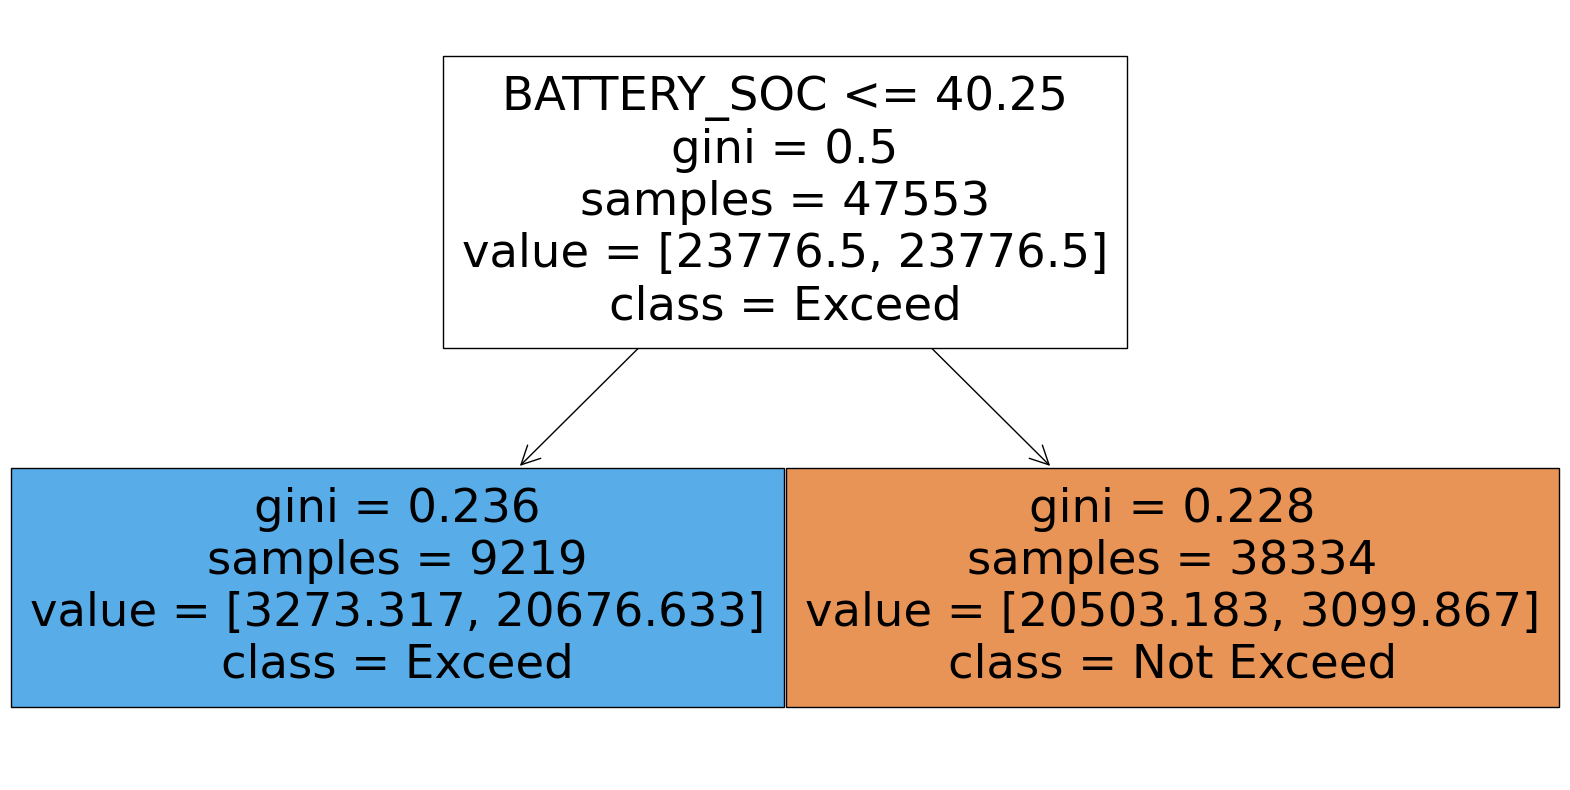

In [ ]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(20,10))  
plot_tree(clf, filled=True, feature_names=features.columns, class_names=['Not Exceed', 'Exceed'])
plt.show()

Awesome. That's the first ground truth rule extracted from the entire dataset.

# Ground truth reconstruction
As discovered during the initial EDA, some parts of the data don't follow ground truth rules mentionel in Danilo's email. The idea is to come up with a subset, that strictly follows the rules, and train a few baseline models that are able to extract ALL of the ground truth rules from that dataset. The model can then be tested onthe large dataset. Similarly should be done with a neuro-symbolic approach - LTNs?

The following are relevant ground truths (some are excluded, since they can't be extracted - see EDA section):

- 40% < SOC < 80%:
    - if GARAGE_EXTERNAL_POWER > DEMAND_LIMIT, e-cars charging power is covered by local battery.
- SOC < 40%:
    - if GARAGE_EXTERNAL_POWER > DEMAND_LIMIT, e-cars charging power is covered by local battery.
    - If GARAGE_EXTERNAL_POWER < DEMAND_LIMIT, local battery is charged from the grid.
- SOC < 15%: Battery discharging is stopped due to battery health

First, we ONLY FOCUS ON STATIC LIMIT DATA.

`ISSUE:` In the second rule, how can we know when peak-shaving is happening? If GARAGE_EXTERNAL is <50, does that mean that battery discharge power should be 0? Should batteries only be utilized when GARAGE_EXTERNAL == 50? There are no instances where GARAGE_EXTERNAL is exactly 50.....

In [ ]:
delta = 0.5 # Tolerance for the power limit
SOC_less_15 = s_data[(s_data["BATTERY_SOC"]<15) & (s_data["BATTERY_DISCHARGE_POWER"]<=0)]
SOC_less_40_1 = s_data[(s_data["BATTERY_SOC"]<40) & (s_data["GARAGE_EXTERNAL_POWER"]<50) & (s_data["BATTERY_DISCHARGE_POWER"]<0)]
SOC_less_40_2 = s_data[(s_data["BATTERY_SOC"]<40) & (s_data["GARAGE_EXTERNAL_POWER"]<=(50+delta)) & ((50-delta)<=s_data["GARAGE_EXTERNAL_POWER"]) & (s_data["BATTERY_DISCHARGE_POWER"]>=0)]
SOC_more_40 = s_data[(s_data["BATTERY_SOC"]>=40) & (s_data["GARAGE_EXTERNAL_POWER"]<delta)]

In [ ]:
df_GT = pd.concat([SOC_less_15, SOC_less_40_1, SOC_less_40_2, SOC_more_40], ignore_index=True)
df_GT = df_GT.drop_duplicates()
print(f"Percentage of dataset, that is kept: {len(df_GT)/len(s_data)*100}%")

Percentage of dataset, that is kept: 19.49968036068773%


That's kinda yikes. Less than 20% of original dataset follows the ground-truth rules. Let's try anyways.

In [ ]:
tree = DecisionTreeClassifier(random_state=42, max_depth=1, class_weight='balanced')
tree.fit(df_GT.drop(['POWER_EXCEEDS_LIMIT', '_time', 'GARAGE_EXTERNAL_POWER', 'POWER_SUPPLY', 'POWER_DEMAND', 'BATTERY_DISCHARGE_POWER'], axis=1), df_GT['POWER_EXCEEDS_LIMIT'])


DecisionTreeClassifier(class_weight='balanced', max_depth=1, random_state=42)

[Text(0.5, 0.75, 'WALLBOX_FASTCHARGER_ENERGY <= 44.243\ngini = 0.5\nsamples = 11591\nvalue = [5795.5, 5795.5]\nclass = Exceed'),
 Text(0.25, 0.25, 'gini = 0.138\nsamples = 7702\nvalue = [4590.327, 370.958]\nclass = Not Exceed'),
 Text(0.75, 0.25, 'gini = 0.297\nsamples = 3889\nvalue = [1205.173, 5424.542]\nclass = Exceed')]

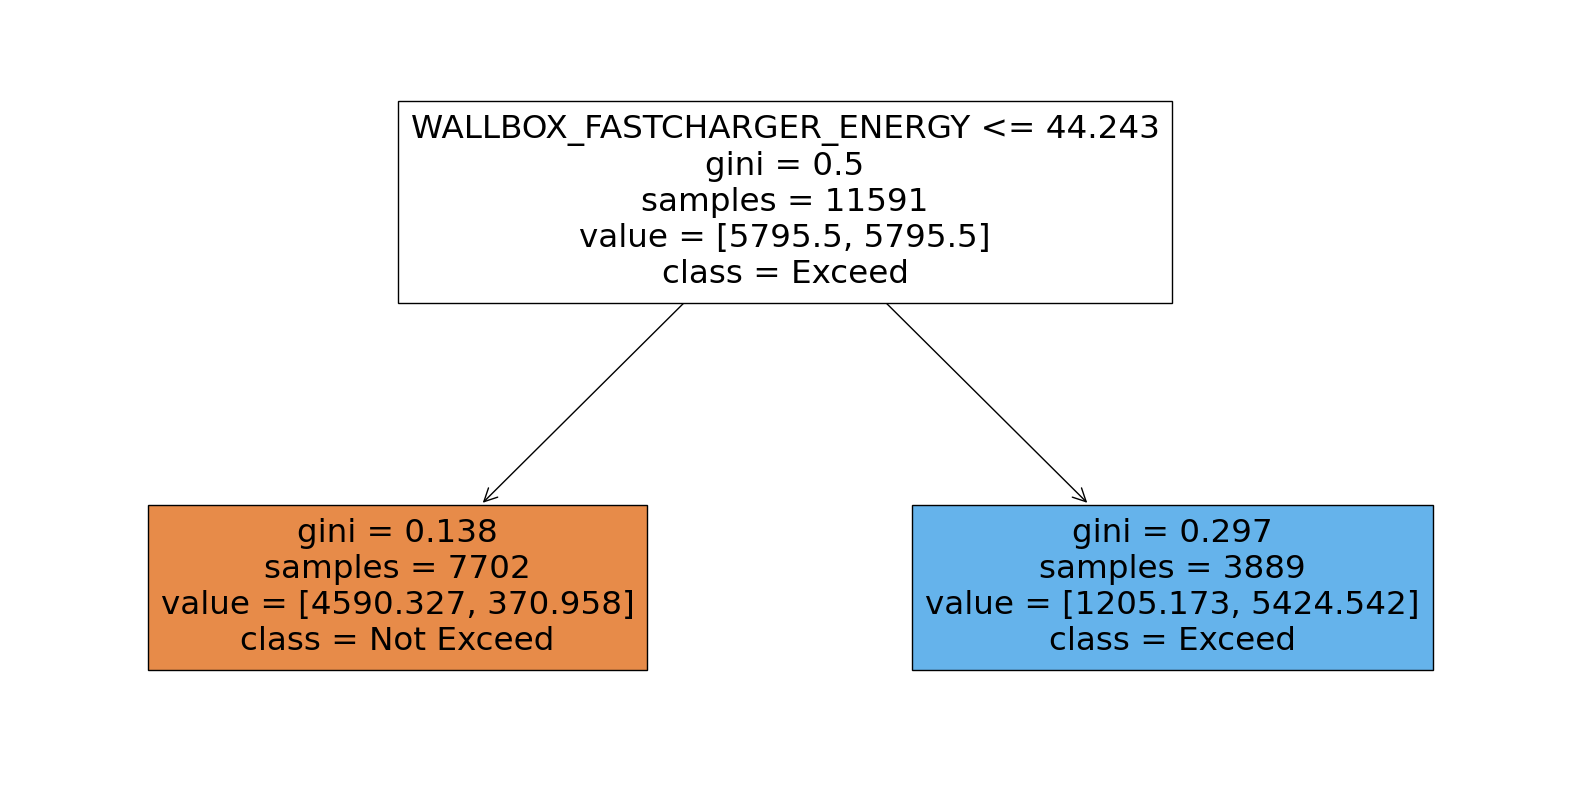

In [ ]:
plt.figure(figsize=(20,10))
plot_tree(tree, filled=True, feature_names=features.columns, class_names=['Not Exceed', 'Exceed'])

Are we even predicting the right thing?

In [ ]:
df_GT["DRAWN_FROM"] = df_GT.apply(lambda x: "Battery" if (x["BATTERY_DISCHARGE_POWER"]>0) & (x["GARAGE_EXTERNAL_POWER"]<0) else "Grid" if (x["BATTERY_DISCHARGE_POWER"]<0) & (x["GARAGE_EXTERNAL_POWER"]>0) else "Both", axis=1)

In [ ]:
DROPPED_COLUMNS = ['DRAWN_FROM', '_time', 'GARAGE_EXTERNAL_POWER', 'POWER_SUPPLY', 'BATTERY_DISCHARGE_POWER', 'POWER_DEMAND_EXCEEDS_SUPPLY', 'POWER_EXCEEDS_LIMIT']
tree = DecisionTreeClassifier(random_state=42, max_depth=2, class_weight='balanced')
y = df_GT['DRAWN_FROM']
X = df_GT.drop(DROPPED_COLUMNS, axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
tree.fit(X_train, y_train)
accuracy = accuracy_score(y_test, tree.predict(X_test))
print(f"Balanced accuracy: {accuracy}")

Balanced accuracy: 0.9801638637343683


[Text(0.5, 0.8333333333333334, 'BATTERY_DISCHARGED_ENERGY <= 0.049\ngini = 0.667\nsamples = 11591\nvalue = [3863.667, 3863.667, 3863.667]\nclass = Both'),
 Text(0.25, 0.5, 'POWER_DEMAND <= 48.84\ngini = 0.074\nsamples = 7596\nvalue = [0.0, 154.131, 3827.11]\nclass = Grid'),
 Text(0.125, 0.16666666666666666, 'gini = 0.028\nsamples = 7394\nvalue = [0.0, 53.898, 3777.682]\nclass = Grid'),
 Text(0.375, 0.16666666666666666, 'gini = 0.442\nsamples = 202\nvalue = [0.0, 100.232, 49.429]\nclass = Both'),
 Text(0.75, 0.5, 'BATTERY_SOC <= 39.75\ngini = 0.505\nsamples = 3995\nvalue = [3863.667, 3709.536, 36.557]\nclass = Battery'),
 Text(0.625, 0.16666666666666666, 'gini = 0.019\nsamples = 3993\nvalue = [0.0, 3709.536, 36.042]\nclass = Both'),
 Text(0.875, 0.16666666666666666, 'gini = 0.0\nsamples = 2\nvalue = [3863.667, 0.0, 0.515]\nclass = Battery')]

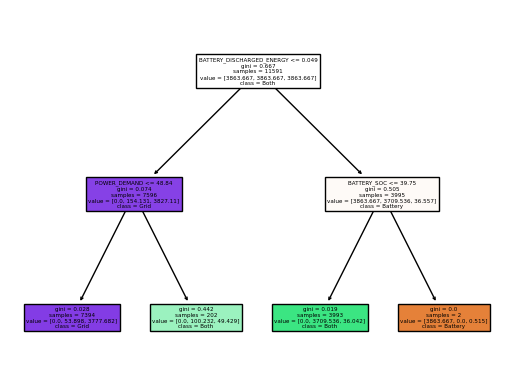

In [ ]:
#Fit on the entire dataset
tree.fit(X, y)
plot_tree(tree, filled=True, feature_names=X.columns, class_names=['Battery', 'Both', 'Grid'])

We can again see the battery SOC = 40 threshold.

We can try to estimate how bad the situation is by bootstrapping and checking in how many casses Battery SOC is in one of the nodes.

Percentage of trees where BATTERY_SOC is in at least one of the nodes: 58%. Calculated on 100 bootstrapped trees.


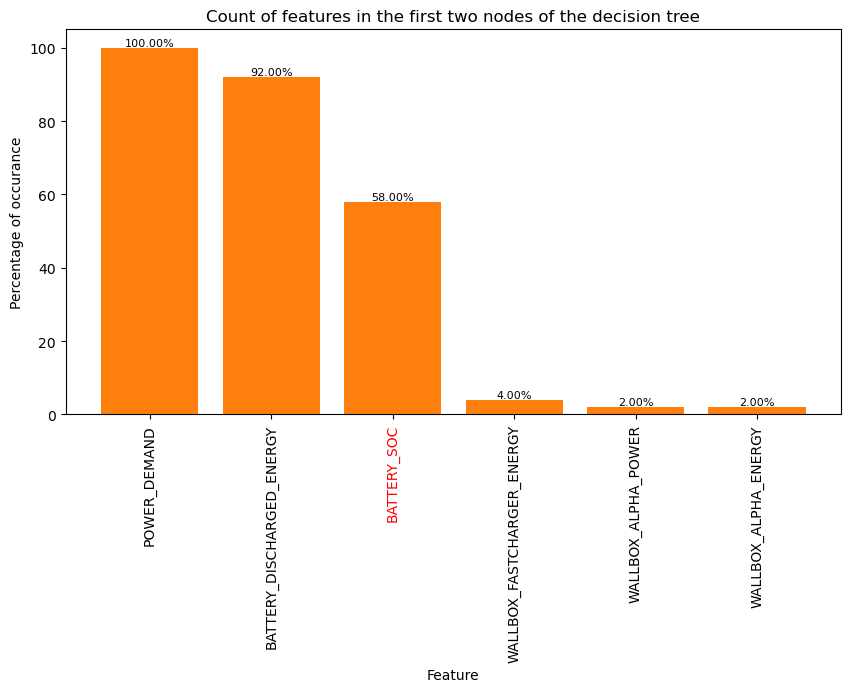

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample

n_iterations = 100

features = {}

for _ in range(n_iterations):
    sample = resample(df_GT)
    y = sample['DRAWN_FROM']
    X = sample.drop(DROPPED_COLUMNS, axis=1)
    
    tree = DecisionTreeClassifier(max_depth=2, class_weight='balanced')
    tree.fit(X, y)
    # sample = sample.drop(DROPPED_COLUMNS, axis=1)
    
        
    # I'm not sure how he features are indexed........
    for feature in X.columns:
        feature_index = X.columns.get_loc(feature)
        if feature_index in tree.tree_.feature and feature_index != -2:
            if feature in features:
                features[feature] += 1
            else:
                features[feature] = 1



features = dict(sorted(features.items(), key=lambda item: item[1], reverse=True))
percentage_values = [(count / n_iterations) * 100 for count in features.values()]
print(f"Percentage of trees where BATTERY_SOC is in at least one of the nodes: {features['BATTERY_SOC']}%. Calculated on {n_iterations} bootstrapped trees.")
# Plot the dictionary
plt.figure(figsize=(10,5))
bars = plt.bar(features.keys(), percentage_values)
plt.bar(features.keys(), percentage_values)
xtick_labels = features.keys()
for i, label in enumerate(xtick_labels):
    if label == "BATTERY_SOC":
        plt.gca().get_xticklabels()[i].set_color('red')
    else:
        plt.gca().get_xticklabels()[i].set_color('black')
for bar, value in zip(bars, percentage_values):
    plt.text(bar.get_x() + bar.get_width() / 2, value, f'{value:.2f}%', ha='center', va='bottom', fontsize=8)
plt.xticks(rotation=65, fontsize=10)
plt.ylabel('Percentage of occurance')
plt.title('Count of features in the first two nodes of the decision tree')
plt.show()